# Perfoming both:

1 pixel level 2d balmer decrement calculation

2 profiles from elliptical annulei photometry

In [23]:
from    astropy.table       import Table
from    scripts.tools       import *
import  numpy               as     np
from    astropy.io          import fits
from    astropy.cosmology   import Planck18
import  astropy.units       as     u
from    scipy.constants     import arcsec
import  matplotlib.pyplot   as     plt
import  matplotlib.colors   as     colors  
import  matplotlib
from    functools           import reduce
from    tqdm             import tqdm
import  gc                                         
import  warnings
from    scripts.tools       import *
from    scripts.packman     import *
import  sys, os
from    IPython.display     import clear_output
from    time                import sleep
from    astropy.wcs         import WCS
from    photutils.aperture  import EllipticalAnnulus, EllipticalAperture, aperture_photometry, CircularAperture, CircularAnnulus



warnings.filterwarnings("ignore")
# Avoid division by zero
np.errstate(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore", message="marker is redundantly defined")

# 1 pixel level balmer decrement

In [150]:
#calculate distance of each pixel to center:
def pixel_to_center_distance(pixel_length):
    y,x = np.indices((50,50))
    center = (np.array((50,50)) - 1) / 2
    distance = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    return (distance*pixel_length).value

#this is the joint function that:
#1. calculate the 2d map of balmer decrement + error
#calculate each pixel distance using redshift + return a table of balmer decrement vs distance
def extract_radial_profile(obj,
                            LINE_HA='LINE_HA',LINE_HB='LINE_HB_CONV',
                            LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV'):
    try:
        if os.path.exists(f"data_extracted/{file_name(obj,prefix='rad')}"):
            return f"{obj['subfield']}-{obj['ID']} already processed, skipping."
        #load corresponding extracted file
        path = f"data_extracted/{file_name(obj,'extracted')}"
        with fits.open(path,mode='update') as extracted:

            #seg ha hb from extracted data
            seg = find_data('SEG',extracted)[1].data == obj['ID']
            ha  = find_data(LINE_HA,extracted)[1]
            hb  = find_data(LINE_HB,extracted)[1]
            err_ha = find_data(LINEWHT_HA,extracted)[1].data**(-0.5)
            err_hb = find_data(LINEWHT_HB,extracted)[1].data**(-0.5)
            #this mask out all the the negative pixel due to continium oversubtraction
            mask1 = np.logical_and(find_data('LINE_HA',extracted)[1].data>0, find_data('LINE_HB',extracted)[1].data>0)
            mask2 = np.logical_and(ha.data>0,hb.data>0)
            mask  = np.logical_and(np.logical_and(mask1,mask2),seg)

            #pixel length from redshift, !! here angular diameter distance is used
            pixel_length = ha.header['PIXASEC'] * arcsec * Planck18.angular_diameter_distance(obj['z_MAP']).to(u.kpc)
            distances  = pixel_to_center_distance(pixel_length)[mask]
            sort = np.argsort(distances)
            #this gives the distance sorted out.
            distances = distances[sort]
            
            #this part calculate the actual 2d balmer decrement + error
            balmer_2d     = fits.ImageHDU(data = ha.data/hb.data,name = '2D_BALMER')
            #error propagation for balmer decrement
            balmer_2d_err = fits.ImageHDU(data = (err_ha**2/hb.data**2 + ha.data**2 * err_hb**2/hb.data**2)**0.5,name = '2D_BALMER_ERR')


            ha_pix = ha.data[mask][sort]
            hb_pix = hb.data[mask][sort]
            ha_pix_err = err_ha[mask][sort]
            hb_pix_err = err_hb[mask][sort]
            balmer_pix     = balmer_2d.data[mask][sort]
            balmer_pix_err = balmer_2d_err.data[mask][sort]

            dtype = [('DISTANCE [kpc]', 'f4'), ('ha', 'f4'), ('ha_err', 'f4'), ('hb', 'f4'), ('hb_err', 'f4'), ('balmer', 'f4'), ('balmer_err', 'f4')]
            name = f'PIX_RAD_PROFILE'
            balmer_table = fits.BinTableHDU(np.array(list(zip(distances, ha_pix, ha_pix_err, hb_pix, hb_pix_err, balmer_pix, balmer_pix_err)), dtype=dtype), name=name)
            #this is the distance sorted out
            #save update
            save_update(balmer_2d,extracted)
            save_update(balmer_2d_err,extracted)
            #save_update(balmer_table,extracted)
            extracted.flush()
            balmer_table.writeto(f"data_extracted/{file_name(obj,prefix='rad')}", overwrite=True)
        return f"{obj['subfield']}-{obj['ID']} processed"
    except Exception as e:
        print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        return f"{obj['subfield']}-{obj['ID']} error: {e}"

from    concurrent.futures  import ThreadPoolExecutor, as_completed
def cat_process(obj_lis, max_threads=1):
        results = []
        if max_threads > 1 :
            with ThreadPoolExecutor(max_threads) as executor:
                futures = {executor.submit(
                    extract_radial_profile,
                    obj): obj for obj in obj_lis}
                for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                    results.append(future.result())
            return results
        else:
            for obj in tqdm(obj_lis):
                results.append(extract_radial_profile(obj))
            return results

def main():
    obj_lis = Table.read('obj_lis_selected.fits')
    results = cat_process(obj_lis, max_threads=15)
    errorcounting(results)

if __name__ == '__main__' :
    main()

100%|██████████| 545/545 [05:16<00:00,  1.72it/s]

total number of obj processed: 545
number of failed obj 0


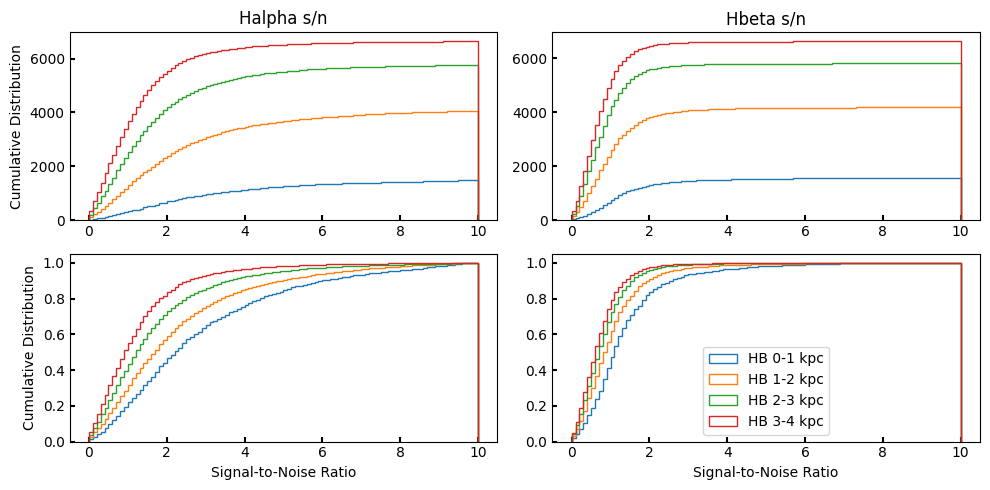

In [153]:
obj_lis = Table.read('obj_lis_selected.fits')
sn_ha = np.array([])
sn_hb = np.array([])
r_lis = np.array([])
for obj in obj_lis:
    try:
        with fits.open(f"data_extracted/{file_name(obj,prefix='rad')}", mode='update') as hdu:
            table = hdu[1]
            r, ha, ha_err, hb, hb_err, balmer, balmer_err = table.data['DISTANCE [kpc]'], table.data['ha'], table.data['ha_err'], table.data['hb'], table.data['hb_err'], table.data['balmer'], table.data['balmer_err']
            sn_ha = np.append(sn_ha, ha / ha_err)
            sn_hb = np.append(sn_hb, hb / hb_err)
            r_lis = np.append(r_lis, r)
    except Exception as e:
        print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        continue

plt.figure(figsize=(10, 5))
#first subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 1)
    plt.title('Halpha s/n')
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.ylabel('Cumulative Distribution')
    plt.subplot(2,2,3)
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)


plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Cumulative Distribution')
#second subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 2)
    plt.title('Hbeta s/n')
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.subplot(2,2,4)
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)

    plt.legend()
plt.xlabel('Signal-to-Noise Ratio')
plt.tight_layout()

# 2 Photometry using elliptical annulei

Here I also implement the code sbcontrast from Pieter Van Dokkum to estimate the background level for aperture photometry, i.e. detection limit as a function of different sizes of aperture

In [ ]:
import sbcontrast as sbc
from scipy.ndimage import binary_dilation
from astropy.stats import sigma_clip

#we try to generate a series of elliptial annuli to perfom aperture photometry
def ellip_aperture_series(obj, linemap):
    # The axis ratio
    q = obj['q']
    # The position angle
    pa = obj['pa']
    # The center of the object
    center = ((linemap.data.shape[0]-2) / 2, (linemap.data.shape[1]-2) / 2)
    # We now generate a series of elliptical annuli with the same width
    # radius gitter 
    r = np.linspace(0, linemap.data.shape[0]/2, int((linemap.data.shape[0]+1)/2))
    r = r[r/q < ((linemap.data.shape[0]-1)/2)] 

    center_annuli = [EllipticalAperture(center, r[1], r[1]*q , theta= -(90-pa) * u.deg.to(u.rad))]
    ellip_annuli = [EllipticalAnnulus(center, a_in=r[i], a_out=r[i+1], b_in=r[i]*q, b_out=r[i+1]*q, theta= -(90 -pa) * u.deg.to(u.rad) ) for i in range(1, len(r)-2)]
    final_aperture = center_annuli + ellip_annuli

    return (r[:-1]+r[1:])/2, final_aperture[:-1]


def radial_profile(obj, linemap, weight, seg, pixel_length,ha=False):
    
    #print(f"Processing {obj['subfield']}-{obj['ID']} for radial profile extraction")
    
    # Here we try to use elliptical annuli to extract the radial profile
    # The semi major axis in arcsec, transformed to pixel:
    r, apertures = ellip_aperture_series(obj, linemap)
    # Initialize arrays to store the results
    ha_r = np.zeros(len(apertures))
    ha_r_err = np.ones(len(apertures))
    seg_out = np.logical_or(seg != obj['ID'],linemap.data <=0)
    #-------------------------------------------
    # Mask to select the object
    mask_pack = double_packman(linemap.data.shape[0],45,45)
    mask = np.logical_or(seg_out,mask_pack)
    surface_area = [aperture.area_overlap(linemap.data,mask=mask,method='subpixel',subpixels=4) for aperture in apertures]

    # Loop over each annulus and calculate the surface brightness
    for i, annulus in enumerate(apertures):
        phot_table  = aperture_photometry(
            linemap.data, annulus, 
            error=weight.data**-0.5, mask=mask, method='subpixel', subpixels=4)
        ha_r[i]     = phot_table['aperture_sum'][0] / float(surface_area[i])
        ha_r_err[i] = phot_table['aperture_sum_err'][0] / float(surface_area[i])


    #--------------------------------------------
    #Here I use the Pieter van Dokkum's method to calculate the detection limit

    path = f"data_products/{file_name(obj,prefix='full')}"
    name = 'Ha' if ha else 'Hb'
    with fits.open(path) as hdu:
        for image in hdu:
            moasic = None
            if image.header.get('EXTTYPE') == name and (image.name == 'LINE'):
            #if image.name == 'DSCI':
                moasic = image
                break
            
        seg = find_data('SEG',hdu)[1].data
        seg = np.where(seg > 0, 1, 0) #convert to binary mask
        seg[moasic.data == 0] = 1  
    # make the segmentation more aggressive by dilating the mask
        seg = binary_dilation(seg, iterations=5)

        # Pixel area in (arcsec/pixel)²
        pix_scale = moasic.header['PIXASEC']  # arcsec/pixel
        pix_area_scale = pix_scale ** 2
        print(np.nanmean((ha_r/ ha_r_err)[-4:]))
        flux_lim_per_pixel = []
        for i,area in enumerate(surface_area):
            #try:                
                #create a mask to get only the central 80x80 pixels
                start_indexx = (moasic.data.shape[1] - 80) // 2
                start_indexy = (moasic.data.shape[0] - 80) // 2
                end_indexx = start_indexx + 80
                end_indexy = start_indexy + 80

                # Calculate the surface brightness limit using sbcontrast
                limit = sbc.sblimit(image = moasic.data[start_indexy:end_indexy, start_indexx:end_indexx],
                            zeropoint= 1,
                            pix_scale = pix_scale,
                            mask = seg[start_indexy:end_indexy, start_indexx:end_indexx],
                            sigma = 2,#np.min([2,np.nanmedian((ha_r/ ha_r_err))]),
                            scale_arcsec = pix_scale * np.max([1,int(area**0.5)]))
                
                # Convert to flux limit (unit: 1e-17 erg/s/cm²/pix2)
                flux_lim_per_pixel.append(10**( (limit[0][0] - 1) / -2.5)* pix_area_scale)

            #except Exception as e:
            #    print(f"Error calculating flux limit for {obj['subfield']}-{obj['ID']} at radius {r[i]}: {e}")
            #    flux_lim_per_pixel.append(np.inf)
        
        # Convert to flux limit per pixel (unit: 1e-17 erg/s/cm²)
        #clear_output(wait=True)
    print(flux_lim_per_pixel)
    return r*pixel_length, ha_r, ha_r_err, flux_lim_per_pixel


#this function will generate the             print(r, ha_r, ha_r_err, hb_r, hb_r_err, balmer_r, balmer_r_err)
#radial table for a given object
def gen_radial_table_ellip(obj,
                     LINE_HA='LINE_HA',      LINE_HB='LINE_HB_CONV',
                     LINEWHT_HA='LINEWHT_HA',LINEWHT_HB='LINEWHT_HB_CONV'):
    #try:
        #print(f"Processing {obj['subfield']}-{obj['ID']} ")
        path = f"data_extracted/{file_name(obj,prefix='extracted')}"
        with fits.open(path,mode='update') as hdu:
            table_name = 'RAD_PROFILE_ELLIP'
            #check if the file already has the radial table
            #if find_data(table_name,hdu) != None:
            #    return f"{obj['subfield']}-{obj['ID']} already exists"
            
            if find_data('SEG_MOD',hdu) != None:
                seg_map = find_data('SEG_MOD',hdu)[1].data
            else:
                seg_map = find_data('SEG',hdu)[1].data

            #extract the radial profile surface brightness
            r, ha_r, ha_r_err, ha_limit = radial_profile(obj,
                                            linemap      = find_data(LINE_HA,hdu)[1],
                                            weight       = find_data(LINEWHT_HA,hdu)[1],
                                            seg          = seg_map,
                                            pixel_length = obj['pixel_length'],
                                            ha           = True)      
            
            r, hb_r, hb_r_err, hb_limit = radial_profile(obj,
                                            linemap      = find_data(LINE_HB,hdu)[1],
                                            weight       = find_data(LINEWHT_HB,hdu)[1],
                                            seg          = seg_map,
                                            pixel_length = obj['pixel_length'])


            #calculate the balmer decrement
            balmer_r     = ha_r/hb_r
            balmer_r_err =  balmer_r * np.sqrt((ha_r_err / ha_r) ** 2 + (hb_r_err / hb_r) ** 2)
            
            #now calculate the extinction
            #color excess
            E_ba = 2.5*np.log10(balmer_r/2.86)
            #attenutation
            A_ba = E_ba / (K_lambda('Hb')-K_lambda('Ha')) * K_lambda('Ha')

            #columns for the radial table
            cols = [
                fits.Column(name='DISTANCE [kpc]',                       format='E', array=r),
                fits.Column(name='Ha_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=ha_r),
                fits.Column(name='Ha_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=ha_r_err),
                fits.Column(name='Ha_SURF_BRIGHT_LIMIT [1e-17 erg/s/cm2]', format='E', array=ha_limit),
                fits.Column(name='Hb_SURF_BRIGHT [1e-17 erg/s/cm2]',     format='E', array=hb_r),
                fits.Column(name='Hb_SURF_BRIGHT_err [1e-17 erg/s/cm2]', format='E', array=hb_r_err),
                fits.Column(name='Hb_SURF_BRIGHT_LIMIT [1e-17 erg/s/cm2]', format='E', array=hb_limit),
                fits.Column(name='BALMER_DECREM',                        format='E', array=balmer_r),
                fits.Column(name='BALMER_DECREM_ERR',                    format='E',array=balmer_r_err),
                fits.Column(name='E_BV',                                  format='E', array=E_ba),
                fits.Column(name='A_Ha',                                  format='E', array=A_ba)
            ]
            new_table = fits.BinTableHDU.from_columns(cols, name=table_name)
            #save or update table
            save_update(new_table,hdu)
            #save_update(new_table_pix,hdu)
            hdu.flush()


            #clear_output(wait=True)
            return f"{obj['subfield']}-{obj['ID']} processed"
    #except Exception as e:
    #        return f"! {obj['subfield']}-{obj['ID']} failed, error{e}"


## making diagnostic plots

In [31]:
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch
from matplotlib import cm
from photutils.aperture import EllipticalAperture
from astropy.visualization import LogStretch, ImageNormalize
%matplotlib inline
obj_lis = Table.read('obj_lis_selected.fits')
#plot 4x2 images 1st row: imshow ['DSCI', 'LINE_HA', 'LINE_HB_CONV', '2D_BALMER']
#2nd row: imshow I will do later

#for plotting I set a series colorblind safe colors in hexcode
color1 = '#1b9e77'
color2 = '#d95f02'
color3 = '#7570b3'

def make_diagnostic_plots(obj):
        #try:
            plt.figure(figsize=(15,10))
            #set the title, re q pa, sn_ha sn_hb
            #plt.suptitle(f"{obj['subfield']}-{obj['ID']}, {obj['manual_select']} \n re={obj['re']:.2f} kpc, q={obj['q']:.2f}, pa={obj['pa']:.2f} deg, \n sn_ha={obj['sn_ha']:.2f}, sn_hb={obj['sn_hb']:.2f}", fontsize=16)
            #tight layout
            plt.tight_layout()

            path = f"data_extracted/{file_name(obj, prefix='extracted')}"
            with fits.open(path) as hdu:
                #find segmentation map
                seg = find_data('SEG', hdu)[1].data == obj['ID']

                #store the effective radius, position angle and axis ratio
                re = obj['re']/0.1; q = obj['q']; pa = obj['pa']

                for i, name in enumerate(['LINE_HA', 'LINE_HB_CONV','DSCI']):
                    # also embed wcs information
                    # use astropy visualization to plot the image and also stretch the image
                    #if i+1 == 3:
                    #    ax = plt.subplot(2, 3, i+1, projection=WCS(hdu[3].header))
                    #    ax.tick_params(axis='x', labelbottom=False, direction='in', which='both', 
                    #    top=True, right=True, left=True, bottom=True, labelsize=13)
                    #    ax.set_xlabel('RA')
                    #    ax.set_ylabel('DEC')
                    #else:
                    ax = plt.subplot(2, 3, i+1)
                    ax.tick_params(axis='x', labelbottom=False, direction='in', which='both', 
                    top=True, right=True, left=True, bottom=True, labelsize=13)
                    
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])
                    
                    name_dict = {
                        'LINE_HA': 'Hα',
                        'LINE_HB_CONV': 'Hβ',
                        'DSCI': f'{find_data(name,hdu)[1].header["FILTER"]}'
                    }
                    
                    ax.text(
                        0.02, 0.98, f"{name_dict[name]}", transform=ax.transAxes,
                        fontsize=18, color='white', va='top', ha='left',
                        bbox=dict(facecolor='black', alpha=0.3, edgecolor='none', pad=2)
                    )
                    data = find_data(name, hdu)[1].data
                    
                    # Use logarithmic normalization and a better stretch
                    if name == '2D_BALMER':
                        # for 2D_BALMER, we normalize value limits from 0 to 15
                        norm = ImageNormalize(data, vmin=0.1, vmax=15, stretch=LogStretch())
                    else:
                        # avoid zeros and negatives for log stretch
                        masked_data = np.where(data > 0, data, np.nan)
                        norm = ImageNormalize(masked_data, interval=PercentileInterval(99.5), stretch=LogStretch())

                    # plot the segmentation map
                    viridis_cmap = cm.get_cmap('viridis')
                    grey_viridis_cmap = cm.colors.ListedColormap(
                        np.mean(viridis_cmap(np.linspace(0, 1, 256))[:, :3], axis=1, keepdims=True).repeat(3, axis=1))
                    grey_viridis_cmap._init()

                    im1 = ax.imshow(np.where(seg, data, np.nan), origin='lower', norm=norm, cmap='viridis')
                    im2 = ax.imshow(np.where(~seg, data, np.nan), origin='lower', norm=norm, cmap=grey_viridis_cmap, alpha=0.7)
                    # set the title


                    # plot the ellipse at the effective radius for all images, use photutils aperture
                    center = ((data.shape[1]-2)/2, (data.shape[0]-2)/2)
                    aperture = EllipticalAperture(center, a=re, b=re * q, theta=np.deg2rad(pa*u.deg - 90*u.deg))
                    aperture.plot(ax=ax, color='gray', lw=2, alpha=0.8, label='Effective Radius')
                    ax.scatter(center[1], center[0], color='white', s=100, marker='x', label='Center')

                    # Set the axis limits to center a 30x30 region around the image center
                    y, x = center
                    ax.set_xlim(x - 15, x + 15)
                    ax.set_ylim(y - 15, y + 15)

                    # Add colorbar for each subplot
                    #cbar = plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
                    #cbar.set_label('Flux (log stretch)')


                r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_BV, A_Ha = np.vstack(find_data('RAD_PROFILE_ELLIP', hdu)[1].data).transpose()
                #in the following 4 subplots we plot:
                #  1 radial profile (errorbars) of ha,hb together
                #  2 radial profile (errorbars) of s/n of ha,hb together
                #  3 radial profile of balmer decrement, with right y-axis showing the extinction (this plot covers the 7,8 subplots)

                #plot the radial profile of ha and hb
                ax = plt.subplot(2, 3, 4)
                ax.tick_params(axis='x', labelbottom=True, direction='in', which='both', 
                        top=True, right=True, left=True, bottom=True, labelsize=13)
                #plot a grey area representing the effective radius
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(r, ha_r, yerr=ha_r_err, label='Ha', fmt='o:', color=color2, markersize=2,
                    capsize=4, capthick=1.5, elinewidth=1.5)
                #plot halimit as horizontal line
                ax.plot(r, ha_lim, color='darkred', linestyle='-.', label='Ha Limit (alt)')

                ax.set_xlim(-0.2, 10)
                ax.set_xlabel('Distance (kpc)')
                ax.set_title('$H\\alpha$ Surface Brightness')
                ax.set_yscale('log')
                #ax.set_ylim(np.max(hb_r)*10**-4, )
                ax.legend()

                #plot the radial profile of ha and hb s/n
                ax = plt.subplot(2, 3, 5)
                ax.tick_params(axis='x', labelbottom=True, direction='in', which='both', 
                        top=True, right=True, left=True, bottom=True, labelsize=13)
                #plot a grey area representing the effective radius
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(r, hb_r, yerr=hb_r_err, label='Hb', fmt='o:', color=color1, markersize=2,
                    capsize=4, capthick=1.5, elinewidth=1.5)
                #plot hblimit as horizontal line
                ax.plot(r, hb_lim, color='darkgreen', linestyle='-.', label='Hb Limit (alt)')
                                                
                ax.set_xlim(-0.2, 10)
                ax.set_xlabel('Distance (kpc)')
                ax.set_title('$H\\beta$ Surface Brightness')
                ax.set_yscale('log')
                #ax.set_ylim(np.max(hb_r)*10**-4, )
                ax.legend()

                #plot the radial profile of balmer decrement
                ax = plt.subplot(2, 3, 6)
                ax.tick_params(axis='x', labelbottom=True, direction='in', which='both', 
                        top=True, right=True, left=True, bottom=True, labelsize=13)
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(
                    r, balmer_r, yerr=balmer_r_err, label='Balmer Decrement',
                    fmt='o:', color=color3, markersize=4,
                    capsize=4, capthick=1.5, elinewidth=1.5
                )
                ax.axhline(y=2.86, color='green', linestyle='--', label='theory')
                ax.fill_between(r, 2.86*0.8, 2.86*1.2, color='green', alpha=0.2)
                ax.set_xlim(-0.2, 8)
                ax.set_ylim(0, np.nanmin([np.nanmax(balmer_r)+3,25]))
                ax.set_xlabel('Distance [kpc]')
                ax.set_title('Balmer Decrement Ha/Hb')

'''
                #plot the extinction A_Ha
                ax = plt.subplot(2, 4, 8)
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.plot(r, A_Ha, label='A_Ha', color='orange', linestyle='--',marker='o', markersize=4)
                ax.set_xlim(-0.2, 8)
                ax.set_xlabel('Distance [kpc]')
                ax.set_ylabel('Extinction A_Ha')
                ax.set_ylim(-2, 5)
                ax.legend(loc='upper right')
                ax.legend()
'''
        #except Exception as e:
        #    print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")

def main():
    os.makedirs('diagnostic_plots', exist_ok=True)
    os.makedirs('sn0_2', exist_ok=True)
    os.makedirs('sn2_4', exist_ok=True)
    os.makedirs('sn5_10', exist_ok=True)
    os.makedirs('sn10', exist_ok=True)
    for obj in tqdm(Table.read('obj_lis_selected.fits')):
        try:
            result1 = gen_radial_table_ellip(obj)
            clear_output(wait=True)
            print(result1)
            make_diagnostic_plots(obj)
            if   obj['sn_hb'] < 2:
                plt.savefig(f'sn0_2/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            elif obj['sn_hb'] < 4:
                plt.savefig(f'sn3_4/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            elif obj['sn_hb'] < 10:
                plt.savefig(f'sn5_10/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            else:
                plt.savefig(f'sn10/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
main()

GN4-25657 processed


 30%|██▉       | 410/1383 [17:50<42:19,  2.61s/it]


KeyboardInterrupt: 

GN2-10284 processed


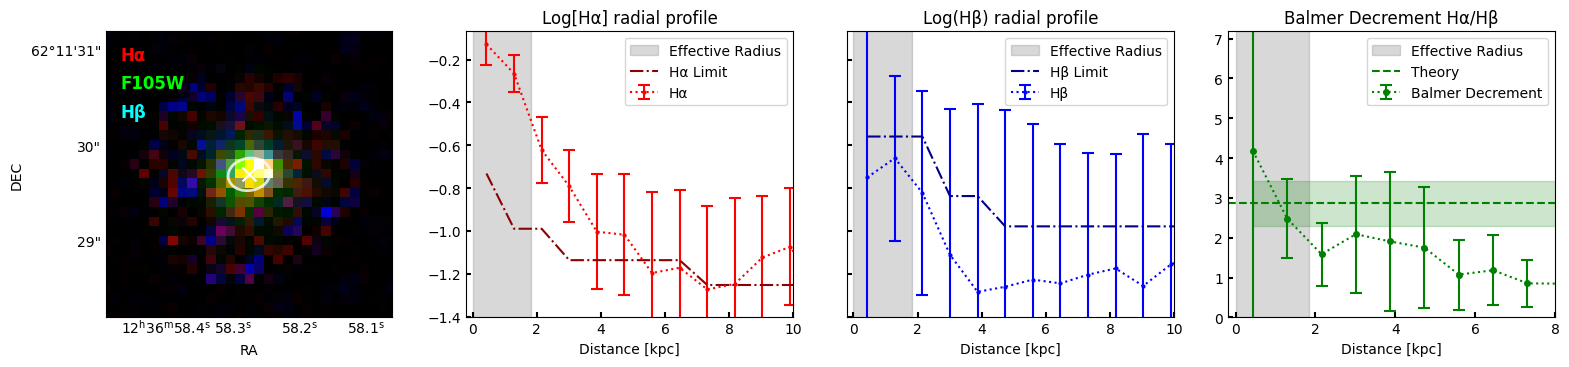

100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


In [42]:
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch
from matplotlib import cm
from photutils.aperture import EllipticalAperture
from astropy.visualization import LogStretch, ImageNormalize
%matplotlib inline
obj_lis = Table.read('obj_lis_selected.fits')
obj_lis = obj_lis[obj_lis['manual_select']=='keep']
#plot 4x2 images 1st row: imshow ['DSCI', 'LINE_HA', 'LINE_HB_CONV', '2D_BALMER']
#2nd row: imshow I will do later

def make_diagnostic_plots(obj):
        #try:
            plt.figure(figsize=(16,4))
            #set the title, re q pa, sn_ha sn_hb
            #plt.suptitle(f"{obj['subfield']}-{obj['ID']}, {obj['manual_select']} \n re={obj['re']:.2f} kpc, q={obj['q']:.2f}, pa={obj['pa']:.2f} deg, \n sn_ha={obj['sn_ha']:.2f}, sn_hb={obj['sn_hb']:.2f}", fontsize=16)
            #tight layout
            #set default tick parameter: all ticks sticks inside all axes
            matplotlib.rcParams['xtick.direction'] = 'in'
            matplotlib.rcParams['ytick.direction'] = 'in'
            #make tick thick
            matplotlib.rcParams['xtick.major.width'] = 1.5
            matplotlib.rcParams['ytick.major.width'] = 1.5
            path = f"data_extracted/{file_name(obj, prefix='extracted')}"
            with fits.open(path) as hdu:
                #find segmentation map
                seg = find_data('SEG', hdu)[1].data == obj['ID']

                #store the effective radius, position angle and axis ratio
                re = obj['re']/0.1; q = obj['q']; pa = obj['pa']

                # Create RGB composite image as first panel
                # Get the three images for RGB composition
                dsci_data = find_data('DSCI', hdu)[1].data
                ha_data = find_data('LINE_HA', hdu)[1].data
                hb_data = find_data('LINE_HB_CONV', hdu)[1].data
                
                # Normalize each channel to 0-1 range using percentile scaling
                def normalize_for_rgb(data, percentile=99.5):
                    # Handle zeros and negatives
                    positive_data = np.where(data > 0, data, np.nan)
                    if np.all(np.isnan(positive_data)):
                        return np.zeros_like(data)
                    # Use percentile interval for robust scaling
                    vmin, vmax = np.nanpercentile(positive_data, [0.5, percentile])
                    normalized = np.clip((data - vmin) / (vmax - vmin), 0, 1)
                    return np.nan_to_num(normalized, nan=0)
                
                # Create RGB channels: R=Ha, G=DSCI, B=Hb
                r_channel = normalize_for_rgb(ha_data)
                g_channel = normalize_for_rgb(dsci_data) 
                b_channel = normalize_for_rgb(hb_data)
                
                # Stack into RGB array
                rgb_image = np.stack([r_channel, g_channel, b_channel], axis=2)
                
                # Apply segmentation mask - make object region brighter, background dimmer
                seg_mask = np.stack([seg, seg, seg], axis=2)
                rgb_composite = np.where(seg_mask, rgb_image, rgb_image * 0.1)
                
                # Plot RGB composite in first panel (no title)
                ax = plt.subplot(1, 4, 1, projection=WCS(hdu[3].header))
                ax.set_xlabel('RA')
                ax.set_ylabel('DEC')
                
                im_rgb = ax.imshow(rgb_composite, origin='lower')
                
                # Add colored text annotations in the RGB image itself
                ax.text(0.05, 0.95, 'Hα', transform=ax.transAxes, fontsize=12, 
                       color='red', fontweight='bold', verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))
                ax.text(0.05, 0.85, f"{find_data('DSCI', hdu)[1].header['Filter']}", transform=ax.transAxes, fontsize=12, 
                       color='lime', fontweight='bold', verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))
                ax.text(0.05, 0.75, 'Hβ', transform=ax.transAxes, fontsize=12, 
                       color='cyan', fontweight='bold', verticalalignment='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))
                
                # plot the ellipse at the effective radius
                center = ((dsci_data.shape[1]-2)/2, (dsci_data.shape[0]-2)/2)
                aperture = EllipticalAperture(center, a=re, b=re * q, theta=np.deg2rad(pa*u.deg - 90*u.deg))
                aperture.plot(ax=ax, color='white', lw=2, alpha=0.8, label='Effective Radius')
                ax.scatter(center[1], center[0], color='white', s=100, marker='x', label='Center')
                
                # Set the axis limits to center a 30x30 region around the image center
                y, x = center
                ax.set_xlim(x - 15, x + 15)
                ax.set_ylim(y - 15, y + 15)

                # Get radial profile data for the surface brightness plots
                r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_BV, A_Ha = np.vstack(find_data('RAD_PROFILE_ELLIP', hdu)[1].data).transpose()

                # Calculate shared y-axis range for panels 2 and 3
                # Combine all y-values from both Hα and Hβ plots
                all_y_values = np.concatenate([
                    np.log10(ha_r), np.log10(ha_lim),
                    np.log10(hb_r), np.log10(hb_lim)
                ])
                # Remove any NaN or infinite values
                valid_y_values = all_y_values[np.isfinite(all_y_values)]
                if len(valid_y_values) > 0:
                    y_min = np.min(valid_y_values)
                    y_max = np.max(valid_y_values)
                    # Add some padding
                    y_range = y_max - y_min
                    y_min -= 0.05 * y_range
                    y_max += 0.05 * y_range
                else:
                    y_min, y_max = -19, -15  # fallback values

                # Panel 2: H-alpha surface brightness (where LINE_HA was)
                ax = plt.subplot(1, 4, 2)
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(r, np.log10(ha_r), yerr=ha_r_err/ha_r, label='Hα', fmt='o:', color='red', markersize=2,
                    capsize=4, capthick=1.5, elinewidth=1.5)
                ax.plot(r, np.log10(ha_lim), color='darkred', linestyle='-.', label='Hα Limit')
                ax.set_xlim(-0.2, 10)
                ax.set_ylim(y_min, y_max)  # Set shared y-axis range
                ax.set_xlabel('Distance [kpc]')
                ax.set_title('Log[Hα] radial profile')
                #ax.set_yscale('log')
                ax.legend()

                # Panel 3: H-beta surface brightness (where LINE_HB_CONV was)
                ax = plt.subplot(1, 4, 3)
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(r, np.log10(hb_r), yerr=hb_r_err/hb_r, label='Hβ', fmt='o:', color='blue', markersize=2,
                    capsize=4, capthick=1.5, elinewidth=1.5)
                ax.plot(r, np.log10(hb_lim), color='darkblue', linestyle='-.', label='Hβ Limit')
                ax.set_xlim(-0.2, 10)
                ax.set_ylim(y_min, y_max)  # Set shared y-axis range
                ax.set_yticklabels([])  # Hide y-ticks for this panel
                ax.set_xlabel('Distance [kpc]')
                ax.set_title('Log(Hβ) radial profile')
                #ax.set_yscale('log')
                ax.legend()

                # Panel 4: Balmer decrement (where 2D_BALMER was)
                ax = plt.subplot(1, 4, 4)
                ax.axvspan(0, re*obj['pixel_length'], color='grey', alpha=0.3, label='Effective Radius')
                ax.errorbar(r, balmer_r, yerr=balmer_r_err, label='Balmer Decrement',
                    fmt='o:', color='green', markersize=4,
                    capsize=4, capthick=1.5, elinewidth=1.5)
                ax.axhline(y=2.86, color='green', linestyle='--', label='Theory')
                ax.fill_between(r, 2.86*0.8, 2.86*1.2, color='green', alpha=0.2)
                ax.set_xlim(-0.2, 8)
                ax.set_ylim(0, np.nanmin([np.nanmax(balmer_r)+3,25]))
                ax.set_xlabel('Distance [kpc]')
                ax.set_title('Balmer Decrement Hα/Hβ')
                ax.legend()
            plt.tight_layout()

        #except Exception as e:
        #    print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")



def main():
    os.makedirs('diagnostic_plots', exist_ok=True)
    os.makedirs('sn0_2', exist_ok=True)
    os.makedirs('sn2_4', exist_ok=True)
    os.makedirs('sn5_10', exist_ok=True)
    os.makedirs('sn10', exist_ok=True)
    for obj in tqdm(Table.read('obj_lis_selected.fits')[:2]):
        try:
            result1 = gen_radial_table_ellip(obj)
            clear_output(wait=True)
            print(result1)
            make_diagnostic_plots(obj)
            if   obj['sn_hb'] < 2:
                plt.savefig(f'sn0_2/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            elif obj['sn_hb'] < 4:
                plt.savefig(f'sn3_4/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            elif obj['sn_hb'] < 10:
                plt.savefig(f'sn5_10/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            else:
                plt.savefig(f'sn10/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
main()

## test

GS2-49902 processed


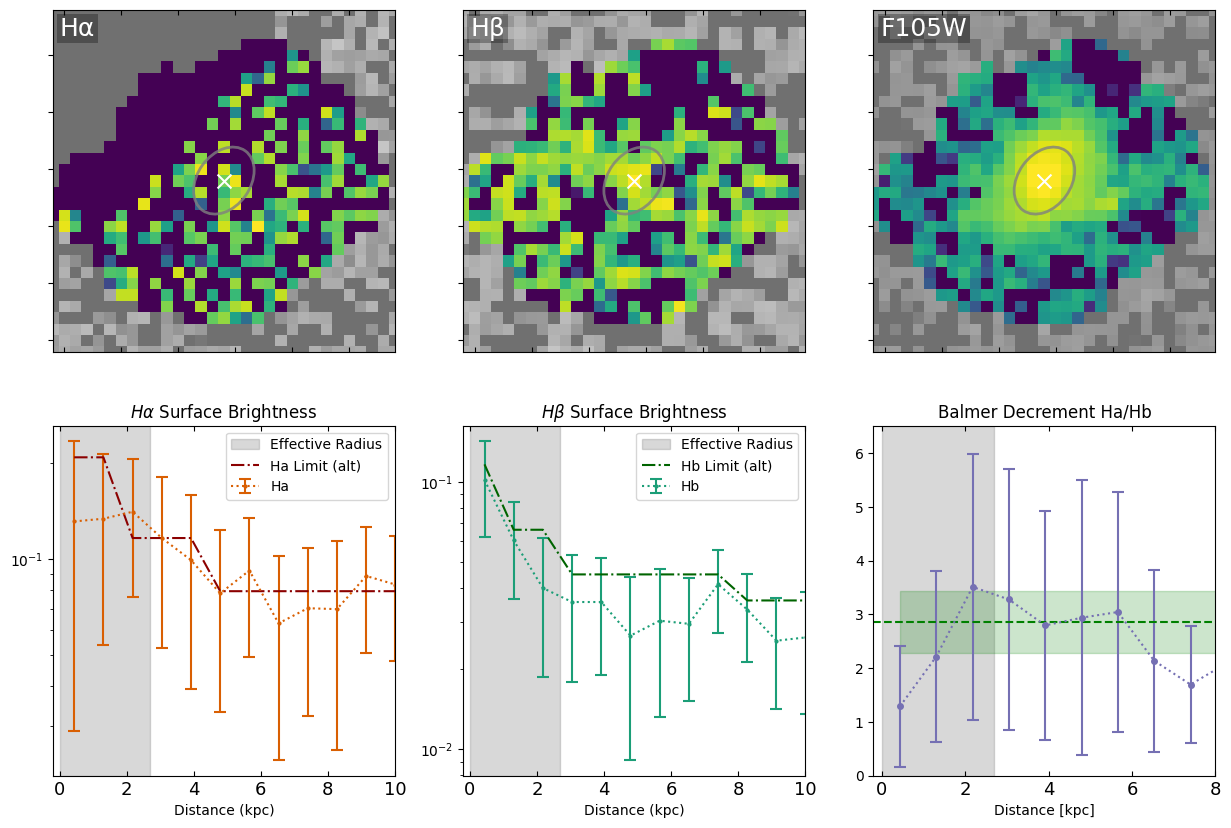

100%|██████████| 552/552 [33:06<00:00,  3.60s/it]


In [4]:

def main():
    os.makedirs('diagnostic_plots', exist_ok=True)
    os.makedirs('sn0_2', exist_ok=True)
    os.makedirs('sn2_4', exist_ok=True)
    os.makedirs('sn5_10', exist_ok=True)
    os.makedirs('sn10', exist_ok=True)
    for obj in tqdm(Table.read('obj_lis_selected.fits')):
        try:
            result1 = gen_radial_table_ellip(obj)
            clear_output(wait=True)
            print(result1)
            make_diagnostic_plots(obj)
            if   obj['sn_hb'] < 2:
                plt.savefig(f'sn0_2/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            elif obj['sn_hb'] < 4:
                plt.savefig(f'sn3_4/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            elif obj['sn_hb'] < 10:
                plt.savefig(f'sn5_10/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            else:
                plt.savefig(f'sn10/{file_name(obj,prefix="diag")}.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
main()

2.5119341245790316
[0.16195798033577727, 0.08888096782133811, 0.08888096782133811, 0.08888096782133811, 0.05995906998783419, 0.08888096782133811, 0.08888096782133811, 0.05995906998783419, 0.05995906998783419, 0.05995906998783419]
1.674475641027311
[0.16195798033577727, 0.08888096782133811, 0.08888096782133811, 0.08888096782133811, 0.05995906998783419, 0.08888096782133811, 0.08888096782133811, 0.05995906998783419, 0.05995906998783419, 0.05995906998783419]
1.674475641027311
[0.1388850365103375, 0.07692534225031036, 0.07692534225031036, 0.07692534225031036, 0.05321478588799686, 0.07692534225031036, 0.07692534225031036, 0.05321478588799686, 0.05321478588799686, 0.05321478588799686]
[0.1388850365103375, 0.07692534225031036, 0.07692534225031036, 0.07692534225031036, 0.05321478588799686, 0.07692534225031036, 0.07692534225031036, 0.05321478588799686, 0.05321478588799686, 0.05321478588799686]


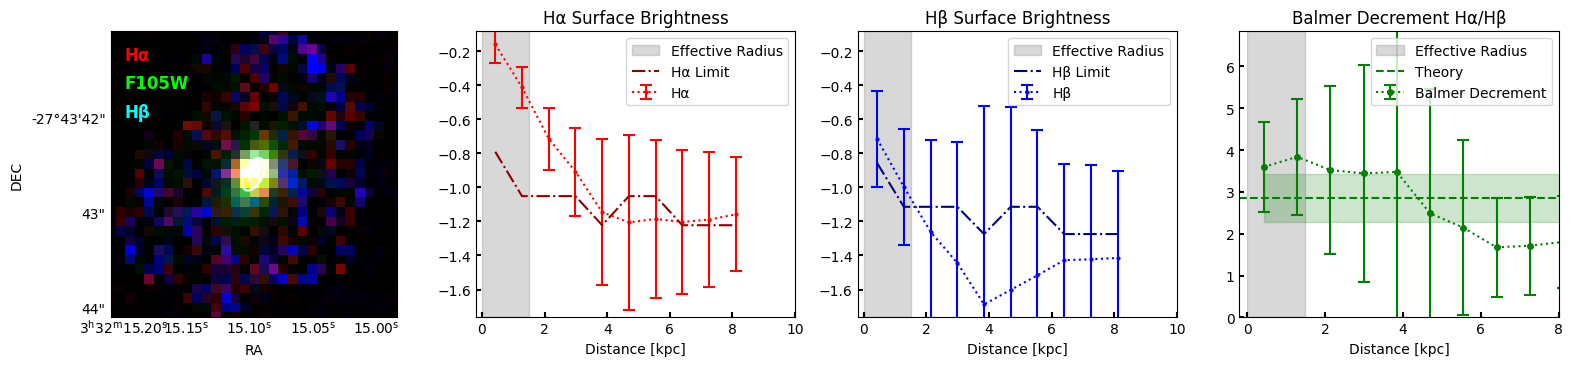

ERSPRIME-39406 processed
ERSPRIME-39406 processed


In [40]:
obj_lis = Table.read('obj_lis_selected.fits')
#use only objects with s/n > 5 for ha and hb
mask = (obj_lis['sn_hb'] > 5)# & (obj_lis['sn_hb'] < 5)
obj_lis = obj_lis[mask]
%matplotlib inline
#give me one random index
index = np.random.randint(0, len(obj_lis))
#print(index)
#index=0
for obj in obj_lis[index:index+1]:
    #try:
        result1 = gen_radial_table_ellip(obj)
        result2 = make_diagnostic_plots(obj)
        plt.show()
        print(result1)
        print(result1)
        #clear_output(wait=True)
    #except Exception as e:
    #    print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        

In [ ]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.visualization import (ImageNormalize, PercentileInterval, AsinhStretch)
from astropy.coordinates import SkyCoord
%matplotlib inline
obj_lis = Table.read('obj_lis_selected.fits')
#while True:
if True:
    for obj in tqdm(obj_lis[:10]):
    #for obj in obj_lis:
        try:
            print(f"Processing {obj['subfield']}-{obj['ID']}")
            # 先定义 re, pa, q
            re = obj['re']
            pa = obj['pa']
            q  = obj['q']
            with fits.open(f"data_extracted/{file_name(obj,prefix='extracted')}") as hdu:
                linemap = find_data('DSCI', hdu)[1]
                r, final_apertures = ellip_aperture_series(obj, linemap)
                img = find_data('DSCI', hdu)[1].data
                try:
                    wcs = WCS(find_data('DSCI', hdu)[1].header)
                except Exception:
                    wcs = None

                norm = ImageNormalize(img, interval=PercentileInterval(99.5), stretch=AsinhStretch())
                plt.figure(figsize=(10, 10))
                if wcs is not None and wcs.has_celestial:
                    ax = plt.subplot(projection=wcs)
                    im = ax.imshow(img, cmap='plasma', norm=norm)
                    ax.set_xlabel('RA')
                    ax.set_ylabel('Dec')
                else:
                    ax = plt.gca()
                    im = ax.imshow(img , cmap='plasma', norm=norm)
                    ax.set_xlabel('X [pixels]')
                    ax.set_ylabel('Y [pixels]')
                plt.colorbar(im, ax=ax, label='Surface Brightness [erg/s/cm^2/arcsec^2]')
                
                plt.title(f"{obj['subfield']}-{obj['ID']} - z={obj['z_MAP']:.3f} \n re={re:.2f} - kpc - PA={pa:.1f} deg - q={q:.2f} - f={obj['f']:.2f}) ")

                # plot the ellipse in effective radius
                #re = 1
                #q = 0.5
                #pa = 30
                ellipse = EllipticalAperture(
                    ((linemap.data.shape[1]-2) / 2, (linemap.data.shape[0]-2) / 2),
                    re / 0.1, 
                    re * q / 0.1, 
                    theta = -(90 -pa) * u.deg   # 修正，保证和PA箭头一致
                )
                ellipse.plot(color='red', lw=2, label='Effective Radius')
                center_x = (linemap.data.shape[1]-2) / 2
                center_y = (linemap.data.shape[0]-2) / 2
                ax.scatter(center_x, center_y, color='blue', marker='x', s=100, label='Center')

                plt.legend()
                #plt.savefig(f'morph_test/{obj["subfield"]}-{obj["ID"]}_morph.png', bbox_inches='tight')
                plt.show()
                sleep(0.5)
                clear_output(wait=True)
                gc.collect()
        except Exception as e:
            print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
            continue

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


## Now I check the s/n of the outcome

  0%|          | 0/286 [00:00<?, ?it/s]

Error processing GS5-37485: not enough values to unpack (expected 11, got 9)


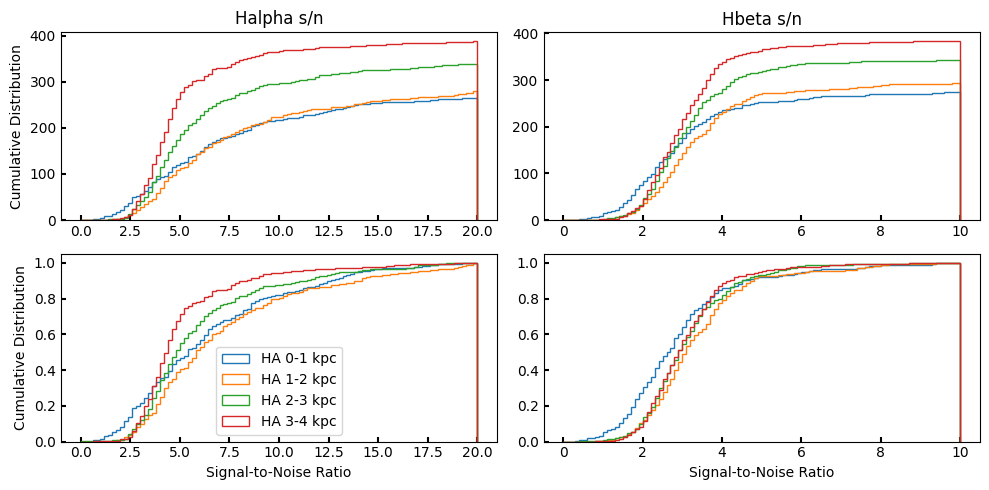

In [ ]:
def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

#immittate the pixel level s.n histogram to plot s/n for annulei photometry
obj_lis = Table.read('obj_lis_selected.fits')
obj_lis = obj_lis[obj_lis['manual_select']=='keep']
sn_ha = np.array([])
sn_hb = np.array([])
r_lis = np.array([])
for obj in tqdm(obj_lis):
    try:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        with fits.open(path) as hdu:
                data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
                r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
                r_center = bin_center(r)
                r_lis = np.append(r_lis, r_center)
                sn_ha = np.append(sn_ha, ha_r / ha_r_err)
                sn_hb = np.append(sn_hb, hb_r / hb_r_err)
    except Exception as e:
        print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        continue

plt.figure(figsize=(10, 5))
#first subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 1)
    plt.title('Halpha s/n')
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20))#,density=True)
    plt.ylabel('Cumulative Distribution')

    plt.subplot(2,2,3)
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20),density=True)
plt.legend()

plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Cumulative Distribution')
#second subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 2)
    plt.title('Hbeta s/n')
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.subplot(2,2,4)
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)
plt.xlabel('Signal-to-Noise Ratio')
plt.tight_layout()


100%|██████████| 93/93 [00:00<00:00, 142.10it/s]


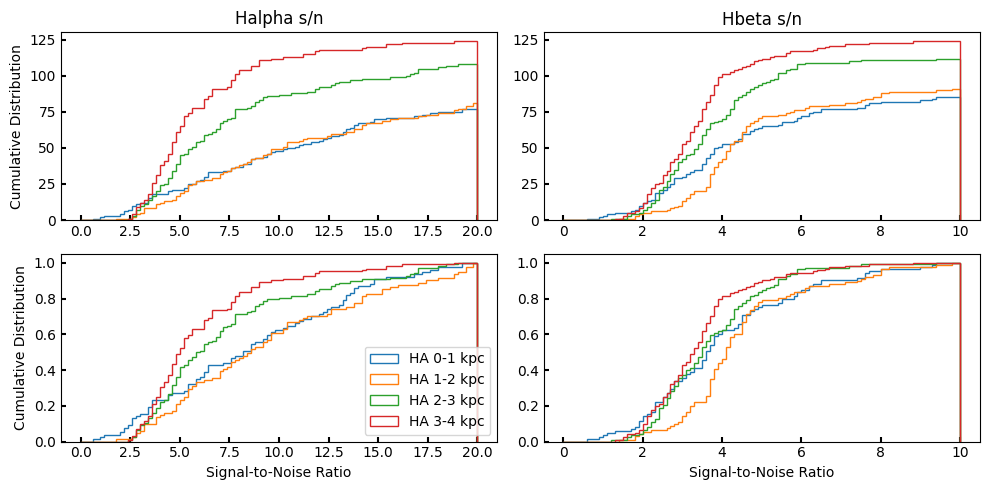

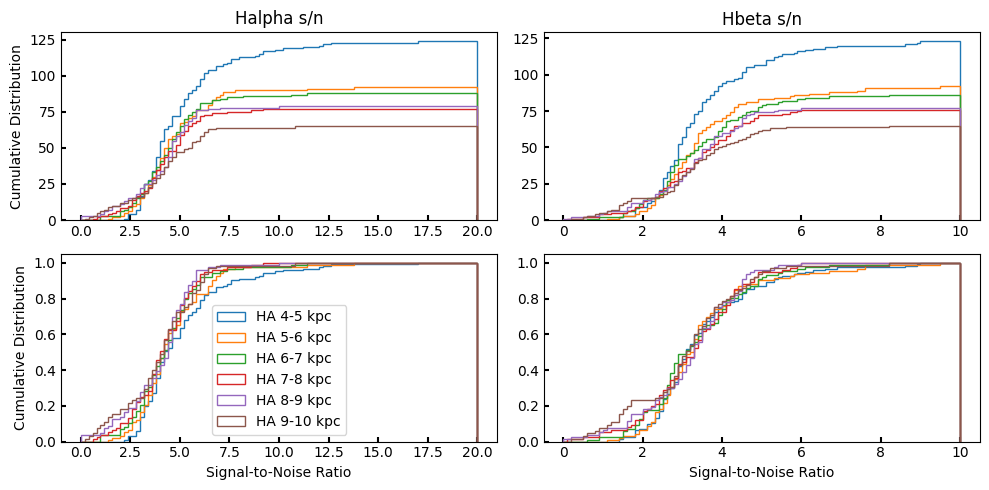

In [243]:
def bin_center(r_lis):
    diff = np.diff(r_lis)  # Calculate differences between consecutive elements
    diff = diff[diff > 0]  # Keep only positive differences
    return r_lis + np.mean(diff) / 2  # Return r_lis plus half the mean of the differences

#immittate the pixel level s.n histogram to plot s/n for annulei photometry
obj_lis = Table.read('obj_lis_selected.fits')
obj_lis = obj_lis[obj_lis['manual_select']=='keep']
obj_lis = obj_lis[(obj_lis['sn_ha'] > 0) & (obj_lis['sn_hb'] > 5)]
sn_ha = np.array([])
sn_hb = np.array([])
r_lis = np.array([])
for obj in tqdm(obj_lis):
    try:
        path = f"data_extracted/{file_name(obj, prefix='extracted')}"
        with fits.open(path) as hdu:
                data = find_data('RAD_PROFILE_ELLIP', hdu)[1].data
                r, ha_r, ha_r_err, ha_lim, hb_r, hb_r_err, hb_lim, balmer_r, balmer_r_err, E_ba, A_a = np.vstack(data).transpose()
                r_center = bin_center(r)
                r_lis = np.append(r_lis, r_center)
                sn_ha = np.append(sn_ha, ha_r / ha_r_err)
                sn_hb = np.append(sn_hb, hb_r / hb_r_err)
    except Exception as e:
        print(f"Error processing {obj['subfield']}-{obj['ID']}: {e}")
        continue

plt.figure(figsize=(10, 5))
#first subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 1)
    plt.title('Halpha s/n')
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20))#,density=True)
    plt.ylabel('Cumulative Distribution')

    plt.subplot(2,2,3)
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20),density=True)
plt.legend()

plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Cumulative Distribution')
#second subplot
for r_range in [[0,1],[1,2],[2,3],[3,4]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 2)
    plt.title('Hbeta s/n')
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.subplot(2,2,4)
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)
plt.xlabel('Signal-to-Noise Ratio')
plt.tight_layout()

#plot scenario for higher radius
plt.figure(figsize=(10, 5))
#first subplot
for r_range in [[4,5],[5,6],[6,7],[7,8],[8,9],[9,10]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 1)
    plt.title('Halpha s/n')
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20))#,density=True)
    plt.ylabel('Cumulative Distribution')

    plt.subplot(2,2,3)
    plt.hist(sn_ha[mask], bins=100, cumulative=True, histtype='step', label=f'HA {r_range[0]}-{r_range[1]} kpc',range=(0,20),density=True)
plt.legend()    
plt.xlabel('Signal-to-Noise Ratio')
plt.ylabel('Cumulative Distribution')
#second subplot
for r_range in [[4,5],[5,6],[6,7],[7,8],[8,9],[9,10]]:
    mask = (r_lis >= r_range[0]) & (r_lis < r_range[1])
    plt.subplot(2, 2, 2)
    plt.title('Hbeta s/n')
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10))#,density=True)
    plt.subplot(2,2,4)
    plt.hist(sn_hb[mask], bins=100, cumulative=True, histtype='step', label=f'HB {r_range[0]}-{r_range[1]} kpc',range=(0,10),density=True)
plt.xlabel('Signal-to-Noise Ratio')
plt.tight_layout()  

In [ ]:
import sbcontrast as sbc
sbc?


Type:        module
String form: <module 'sbcontrast' from '/opt/anaconda3/envs/master_proj/lib/python3.9/site-packages/sbcontrast/__init__.py'>
File:        /opt/anaconda3/envs/master_proj/lib/python3.9/site-packages/sbcontrast/__init__.py
Docstring:   <no docstring>

In [4]:
from astropy.stats import sigma_clip
import numpy as np

data = np.array([1, 2, 2, 3, 100, 2, 3, 2])
clipped_data = sigma_clip(data, sigma=5, maxiters=5)

print(clipped_data)
print(clipped_data.mask)  # True where data is clipped

[1 2 2 3 100 2 3 2]
[False False False False False False False False]
